In [78]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [79]:
import src.ChebNet as ChebNet
import src.CayleyNet as CayleyNet
import src.CORA as CORA
import src.CommunitiesGraph as CommunitiesGraph
import src.utils as utils

In [80]:
# Reload when files are changed
import importlib
importlib.reload(CayleyNet)
importlib.reload(ChebNet)
importlib.reload(CORA)
importlib.reload(CommunitiesGraph)
importlib.reload(utils)

<module 'src.utils' from '/home/infres/avalenca-22/CayleyNets/src/utils.py'>

# CORA dataset

In [19]:
# Import dataset
dataset = CORA.CORA()

Parsing files...
Done.


In [20]:
dataset.print_properties()

CORA dataset
Number of nodes: 2708
Number of edges: 10556
Number of features per node: 1433


In [21]:
# Extended split of the CORA dataset
train_mask, test_mask, val_mask = utils.split_train_test_val(dataset.n, 500, 500) 

In [22]:
# Features and labels as tensors
features = torch.Tensor(1.0*dataset.features).to(device)
labels = torch.Tensor(dataset.labels).long().to(device)
edge_index = dataset.get_edge_index().to(device)

# Masks as tensors
train_mask = torch.Tensor(train_mask).bool().to(device)
test_mask = torch.Tensor(test_mask).bool().to(device)
val_mask = torch.Tensor(val_mask).bool().to(device)

## ChebNet

In [23]:
# Hyperparameters (Section 4.5)
in_feats = dataset.n_features
n_classes = dataset.n_classes
n_hidden = 16
n_hidden_layers = 1 # number of hidden layers
k = 10 # Chebshev polynomial order 
# obs: we weren't able to identify the value of this last parameter in the paper, only that k=2*r where r is the Cayley polynomial order

In [24]:
p_dropout=0.5
normalization = 'sym'
model = ChebNet.ChebNet(in_feats, n_classes, n_hidden, n_hidden_layers, k=k, p_dropout=p_dropout, normalization=normalization).to(device)

In [25]:
print(model)
print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')
print(f'Number of parameters: {sum(p.numel() for p in model.layers[0].parameters())}')
print(f'Number of parameters: {sum(p.numel() for p in model.layers[1].parameters())}')           

ChebNet(
  (layers): ModuleList(
    (0): ChebConv(1433, 16, K=10, normalization=sym)
    (1): ChebConv(16, 7, K=10, normalization=sym)
  )
)
Number of parameters: 230400
Number of parameters: 229280
Number of parameters: 1120


In [26]:
# Optimizer
lr = 5e-3
weight_decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [27]:
# Train the model
epochs=200
loss_values, val_score, train_score = utils.train(model, optimizer, edge_index, features, labels, train_mask, val_mask, epochs, verbose=True)

Epoch 00 | Loss 2.311 | Accuracy (validation) 0.190 | Elapsed time: 0.04s
Epoch 01 | Loss 1.825 | Accuracy (validation) 0.248 | Elapsed time: 0.04s
Epoch 02 | Loss 1.609 | Accuracy (validation) 0.278 | Elapsed time: 0.04s
Epoch 03 | Loss 1.498 | Accuracy (validation) 0.284 | Elapsed time: 0.04s
Epoch 04 | Loss 1.381 | Accuracy (validation) 0.268 | Elapsed time: 0.04s
Epoch 05 | Loss 1.216 | Accuracy (validation) 0.292 | Elapsed time: 0.04s
Epoch 06 | Loss 1.093 | Accuracy (validation) 0.302 | Elapsed time: 0.04s
Epoch 07 | Loss 0.991 | Accuracy (validation) 0.328 | Elapsed time: 0.04s
Epoch 08 | Loss 0.882 | Accuracy (validation) 0.332 | Elapsed time: 0.04s
Epoch 09 | Loss 0.756 | Accuracy (validation) 0.350 | Elapsed time: 0.04s
Epoch 10 | Loss 0.638 | Accuracy (validation) 0.390 | Elapsed time: 0.04s
Epoch 11 | Loss 0.548 | Accuracy (validation) 0.412 | Elapsed time: 0.04s
Epoch 12 | Loss 0.457 | Accuracy (validation) 0.416 | Elapsed time: 0.04s
Epoch 13 | Loss 0.362 | Accuracy (vali

In [28]:
test_score = utils.eval_pytorch_geometric_model(model, edge_index, features, labels, test_mask)
print("Test accuracy {:.3f}".format(test_score))

Test accuracy 0.830


In [29]:
results = {'model': 'ChebNet',
           'dataset': dataset.name,
           'training size': len(train_mask),
           'validation size': len(val_mask),
           'test size': len(test_mask),
           'n hidden nodes': n_hidden,
           'n hidden layers': n_hidden_layers,
           'polynomial order': k,
           'laplacian normalization': normalization,
           'dropout probability': p_dropout,
           'learning rate': lr,
           'weight decay': weight_decay,
           'n epochs': epochs,
           'loss': loss_values,
           'train accuracy': train_score,
           'validation accuracy': val_score,
           'test accuracy': test_score
           }

In [30]:
loaded_results = utils.save_results(results, 'cheb')
# loaded_results = utils.load_results('./results/cheb_2023-12-9-19-36-5.pkl')

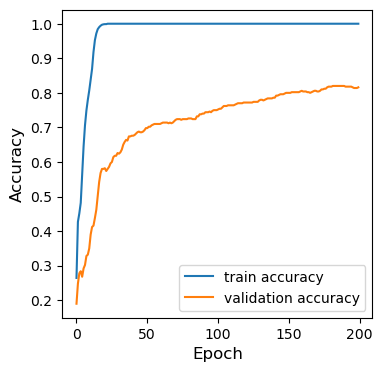

In [50]:
utils.plot_accuracy(loaded_results['train accuracy'], loaded_results['validation accuracy'])

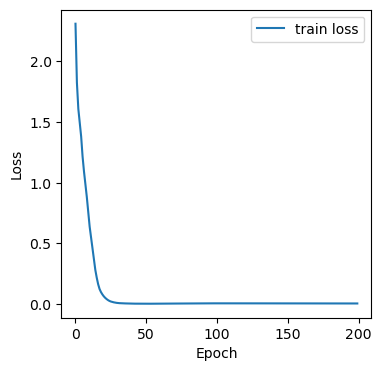

In [51]:
utils.plot_loss(loaded_results['loss'])

In [44]:
print("Test accuracy {:.3f}".format(loaded_results['test accuracy']))

Test accuracy 0.830


## CayleyNet

In [52]:
# Hyperparameters (Section 4.5)
in_feats = dataset.n_features
n_classes = dataset.n_classes
n_hidden = 16
n_hidden_layers = 1 # number of hidden layers
r = 5 # Cayley polynomial order 
# obs: we weren't able to identify the value of this last parameter in the paper

In [53]:
p_dropout=0.5
normalization = 'sym'
model = CayleyNet.CayleyNet(in_feats, n_classes, n_hidden, n_hidden_layers, r=r, p_dropout=p_dropout, normalization=normalization, sparse=False, seed=0)

In [54]:
print(model)
print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')
print(f'Number of parameters: {sum(p.numel() for p in model.layers[0].parameters())}')
print(f'Number of parameters: {sum(p.numel() for p in model.layers[1].parameters())}')           

CayleyNet(
  (layers): ModuleList(
    (0): CayleyConv(1433, 16, r=5, normalization=sym)
    (1): CayleyConv(16, 7, r=5, normalization=sym)
  )
)
Number of parameters: 23042
Number of parameters: 22929
Number of parameters: 113


In [55]:
# Optimizer
lr = 5e-3
weight_decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [56]:
# Train the model
epochs=200
loss_values, val_score, train_score = utils.train(model, optimizer, edge_index, features, labels, train_mask, val_mask, epochs, verbose=True)

Epoch 00 | Loss 2.135 | Accuracy (validation) 0.160 | Elapsed time: 1.57s
Epoch 01 | Loss 1.961 | Accuracy (validation) 0.202 | Elapsed time: 1.54s
Epoch 02 | Loss 1.873 | Accuracy (validation) 0.230 | Elapsed time: 1.54s
Epoch 03 | Loss 1.797 | Accuracy (validation) 0.248 | Elapsed time: 1.54s
Epoch 04 | Loss 1.728 | Accuracy (validation) 0.250 | Elapsed time: 1.54s
Epoch 05 | Loss 1.660 | Accuracy (validation) 0.284 | Elapsed time: 1.54s
Epoch 06 | Loss 1.591 | Accuracy (validation) 0.286 | Elapsed time: 1.54s
Epoch 07 | Loss 1.522 | Accuracy (validation) 0.306 | Elapsed time: 1.54s
Epoch 08 | Loss 1.452 | Accuracy (validation) 0.326 | Elapsed time: 1.54s
Epoch 09 | Loss 1.381 | Accuracy (validation) 0.346 | Elapsed time: 1.55s
Epoch 10 | Loss 1.309 | Accuracy (validation) 0.364 | Elapsed time: 1.55s
Epoch 11 | Loss 1.236 | Accuracy (validation) 0.384 | Elapsed time: 1.55s
Epoch 12 | Loss 1.165 | Accuracy (validation) 0.408 | Elapsed time: 1.54s
Epoch 13 | Loss 1.095 | Accuracy (vali

In [57]:
test_score = utils.eval_pytorch_geometric_model(model, edge_index, features, labels, test_mask)
print("Test accuracy {:.3f}".format(test_score))

Test accuracy 0.788


In [58]:
results = {'model': 'CayleyNet',
           'dataset': dataset.name,
           'training size': len(train_mask),
           'validation size': len(val_mask),
           'test size': len(test_mask),
           'n hidden nodes': n_hidden,
           'n hidden layers': n_hidden_layers,
           'polynomial order': r,
           'laplacian normalization': normalization,
           'dropout probability': p_dropout,
           'learning rate': lr,
           'weight decay': weight_decay,
           'n epochs': epochs,
           'loss': loss_values,
           'train accuracy': train_score,
           'validation accuracy': val_score,
           'test accuracy': test_score
           }

In [63]:
loaded_results = utils.save_results(results, 'cayley')
# loaded_results = utils.load_results(fname)

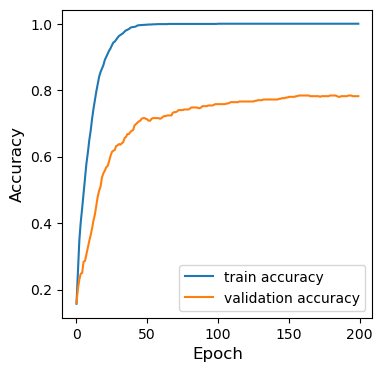

In [64]:
utils.plot_accuracy(loaded_results['train accuracy'], loaded_results['validation accuracy'])

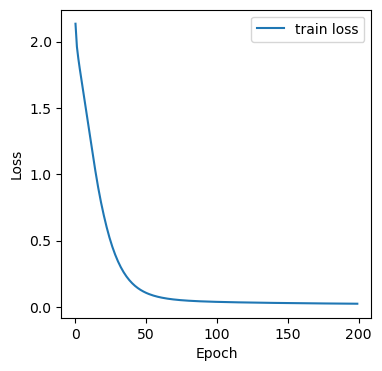

In [65]:
utils.plot_loss(loaded_results['loss'])

In [66]:
print("Test accuracy {:.3f}".format(loaded_results['test accuracy']))

Test accuracy 0.788


# Community detection

In [67]:
# Import dataset
n_community=15
p=0.5
q=0.001
n=1000
dataset = CommunitiesGraph.CommunitiesGraph(n_community, p, q, n)

In [68]:
dataset.print_properties()

Communities dataset
Number of nodes: 1000
Number of edges: 33810
Number of features per node: 1


In [70]:
# Train/test/validation split
train_mask, test_mask, val_mask = utils.split_train_test_val(dataset.n, 0.2, 0.1) 

In [71]:
# Features and labels as tensors
features = torch.Tensor(1.0*dataset.features).to(device)
labels = torch.Tensor(dataset.labels).long().to(device)
edge_index = dataset.get_edge_index().to(device)

# Masks as tensors
train_mask = torch.Tensor(train_mask).bool().to(device)
test_mask = torch.Tensor(test_mask).bool().to(device)
val_mask = torch.Tensor(val_mask).bool().to(device)

## ChebNet

In [95]:
# Hyperparameters (Section 4.5)
in_feats = dataset.n_features
n_classes = dataset.n_classes
n_hidden = 32
n_hidden_layers = 1 # number of hidden layers
k = 10 # Chebshev polynomial order 

In [96]:
p_dropout=0.5
normalization = 'sym'
model = ChebNet.ChebNet(in_feats, n_classes, n_hidden, n_hidden_layers, 
                        k=k, p_dropout=p_dropout, normalization=normalization).to(device)

In [97]:
print(model)
print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')
print(f'Number of parameters: {sum(p.numel() for p in model.layers[0].parameters())}')
print(f'Number of parameters: {sum(p.numel() for p in model.layers[1].parameters())}')           

ChebNet(
  (layers): ModuleList(
    (0): ChebConv(1, 32, K=10, normalization=sym)
    (1): ChebConv(32, 15, K=10, normalization=sym)
  )
)
Number of parameters: 5120
Number of parameters: 320
Number of parameters: 4800


In [98]:
# Optimizer
lr = 5e-3
weight_decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [99]:
# Train the model
epochs=200
loss_values, val_score, train_score = utils.train(model, optimizer, 
                                                  edge_index, features, labels, 
                                                  train_mask, val_mask, epochs, verbose=True)

test_score = utils.eval_pytorch_geometric_model(model, edge_index, features, labels, test_mask)
print("\nTest accuracy {:.3f}".format(test_score))

Epoch 00 | Loss 5.743 | Accuracy (validation) 0.060 | Elapsed time: 0.03s
Epoch 01 | Loss 4.398 | Accuracy (validation) 0.060 | Elapsed time: 0.02s
Epoch 02 | Loss 3.616 | Accuracy (validation) 0.060 | Elapsed time: 0.02s
Epoch 03 | Loss 3.163 | Accuracy (validation) 0.060 | Elapsed time: 0.02s
Epoch 04 | Loss 2.939 | Accuracy (validation) 0.080 | Elapsed time: 0.02s
Epoch 05 | Loss 2.834 | Accuracy (validation) 0.050 | Elapsed time: 0.02s
Epoch 06 | Loss 2.788 | Accuracy (validation) 0.040 | Elapsed time: 0.02s
Epoch 07 | Loss 2.767 | Accuracy (validation) 0.040 | Elapsed time: 0.02s
Epoch 08 | Loss 2.757 | Accuracy (validation) 0.040 | Elapsed time: 0.02s
Epoch 09 | Loss 2.754 | Accuracy (validation) 0.030 | Elapsed time: 0.02s
Epoch 10 | Loss 2.760 | Accuracy (validation) 0.070 | Elapsed time: 0.02s
Epoch 11 | Loss 2.772 | Accuracy (validation) 0.070 | Elapsed time: 0.02s
Epoch 12 | Loss 2.784 | Accuracy (validation) 0.070 | Elapsed time: 0.02s
Epoch 13 | Loss 2.791 | Accuracy (vali

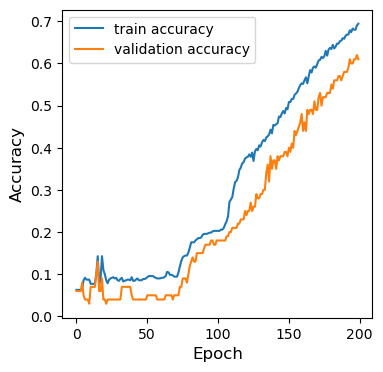

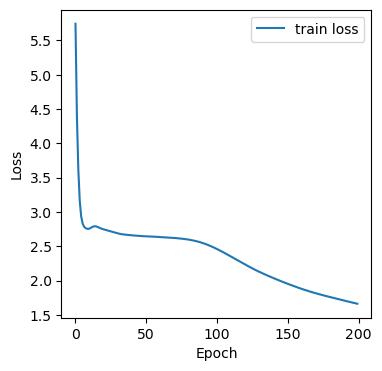

Test accuracy 0.600


In [100]:
results = {'model': 'ChebNet',
           'dataset': dataset.name,
           'training size': len(train_mask),
           'validation size': len(val_mask),
           'test size': len(test_mask),
           'n hidden nodes': n_hidden,
           'n hidden layers': n_hidden_layers,
           'polynomial order': r,
           'laplacian normalization': normalization,
           'dropout probability': p_dropout,
           'learning rate': lr,
           'weight decay': weight_decay,
           'n epochs': epochs,
           'loss': loss_values,
           'train accuracy': train_score,
           'validation accuracy': val_score,
           'test accuracy': test_score
           }

loaded_results = utils.save_results(results, results['model'], results['dataset'])

utils.plot_accuracy(loaded_results['train accuracy'], loaded_results['validation accuracy'])
utils.plot_loss(loaded_results['loss'])
print("Test accuracy {:.3f}".format(loaded_results['test accuracy']))

## CayleyNet

In [85]:
# Hyperparameters (Section 4.5)
in_feats = dataset.n_features
n_classes = dataset.n_classes
n_hidden = 32
n_hidden_layers = 1 # number of hidden layers
r = 5 # Cayley polynomial order 

In [86]:
p_dropout=0.5
normalization = 'sym'
model = CayleyNet.CayleyNet(in_feats, n_classes, n_hidden, n_hidden_layers, r=r, p_dropout=p_dropout, normalization=normalization, sparse=False, seed=0)

/home/infres/avalenca-22/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1133: UserWarning: Complex modules are a new feature under active development whose design may change, and some modules might not work as expected when using complex tensors as parameters or buffers. Please file an issue at https://github.com/pytorch/pytorch/issues/new?template=bug-report.yml if a complex module does not work as expected.
  warnings.warn(


In [87]:
print(model)
print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')
print(f'Number of parameters: {sum(p.numel() for p in model.layers[0].parameters())}')
print(f'Number of parameters: {sum(p.numel() for p in model.layers[1].parameters())}')           

CayleyNet(
  (layers): ModuleList(
    (0): CayleyConv(1, 32, r=5, normalization=sym)
    (1): CayleyConv(32, 15, r=5, normalization=sym)
  )
)
Number of parameters: 514
Number of parameters: 33
Number of parameters: 481


In [88]:
# Optimizer
lr = 5e-3
weight_decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [89]:
# Train the model
epochs=200
loss_values, val_score, train_score = utils.train(model, optimizer, edge_index, features, labels, train_mask, val_mask, epochs, verbose=True)

test_score = utils.eval_pytorch_geometric_model(model, edge_index, features, labels, test_mask)
print("\nTest accuracy {:.3f}".format(test_score))

Epoch 00 | Loss 13.991 | Accuracy (validation) 0.080 | Elapsed time: 0.05s
Epoch 01 | Loss 10.996 | Accuracy (validation) 0.080 | Elapsed time: 0.04s
Epoch 02 | Loss 10.578 | Accuracy (validation) 0.080 | Elapsed time: 0.04s
Epoch 03 | Loss 10.156 | Accuracy (validation) 0.080 | Elapsed time: 0.04s
Epoch 04 | Loss 9.734 | Accuracy (validation) 0.080 | Elapsed time: 0.04s
Epoch 05 | Loss 9.313 | Accuracy (validation) 0.080 | Elapsed time: 0.04s
Epoch 06 | Loss 8.895 | Accuracy (validation) 0.080 | Elapsed time: 0.03s
Epoch 07 | Loss 8.479 | Accuracy (validation) 0.080 | Elapsed time: 0.04s
Epoch 08 | Loss 8.067 | Accuracy (validation) 0.080 | Elapsed time: 0.03s
Epoch 09 | Loss 7.659 | Accuracy (validation) 0.080 | Elapsed time: 0.03s
Epoch 10 | Loss 7.256 | Accuracy (validation) 0.080 | Elapsed time: 0.03s
Epoch 11 | Loss 6.860 | Accuracy (validation) 0.080 | Elapsed time: 0.03s
Epoch 12 | Loss 6.476 | Accuracy (validation) 0.080 | Elapsed time: 0.04s
Epoch 13 | Loss 6.108 | Accuracy (

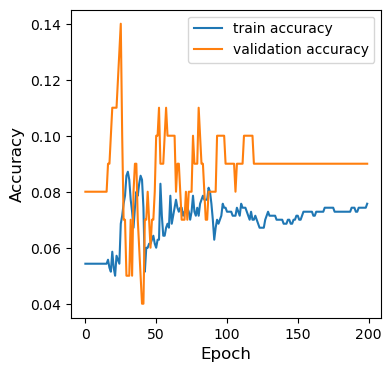

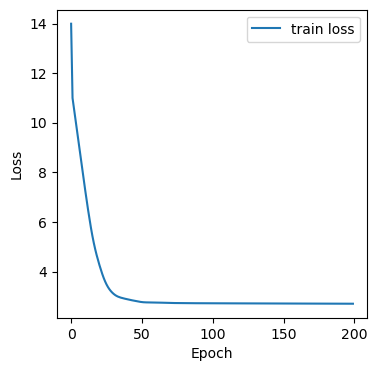

Test accuracy 0.045


In [94]:
results = {'model': 'CayleyNet',
           'dataset': dataset.name,
           'training size': len(train_mask),
           'validation size': len(val_mask),
           'test size': len(test_mask),
           'n hidden nodes': n_hidden,
           'n hidden layers': n_hidden_layers,
           'polynomial order': r,
           'laplacian normalization': normalization,
           'dropout probability': p_dropout,
           'learning rate': lr,
           'weight decay': weight_decay,
           'n epochs': epochs,
           'loss': loss_values,
           'train accuracy': train_score,
           'validation accuracy': val_score,
           'test accuracy': test_score
           }

loaded_results = utils.save_results(results, results['model'], results['dataset'])

utils.plot_accuracy(loaded_results['train accuracy'], loaded_results['validation accuracy'])
utils.plot_loss(loaded_results['loss'])
print("Test accuracy {:.3f}".format(loaded_results['test accuracy']))